## Homework_2023_05_15 时间序列 & 神经网络基础   
教师：胡俊峰

助教：谷东润 陈福康

本次作业总分为13分，达到10分即为满分，另外3分是附加分

注意：为提高大家的知识理解与应用能力，时间序列部分需要你自行发挥的内容较多，这些部分在评分时将不会有硬性的步骤要求，而是根据你完成的质量和分析的质量来综合给分（事实上，整体理解与综合分析能力在时间序列问题中是尤为重要的），不必过于纠结某一具体细节是否在评分标准内，加油！


## 第零部分：请认真阅读代码，理解代码的功能

卡尔曼滤波

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
font = {'family': 'SimSun',
        'size': '10.5' 
        }
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)
 
 
class Kf_Params:
    B = 0  # 外部输入为0
    u = 0  # 外部输入为0
    K = float('nan')  # 卡尔曼增益无需初始化
    z = float('nan')  # 这里无需初始化，每次使用kf_update之前需要输入观察值z
    P = np.diag(np.ones(4))  # 初始P设为0 
 
    # 初始状态：函数外部提供初始化的状态，本例使用观察值进行初始化，vx，vy初始为0
    x = []
    G = []
 
    # 状态转移矩阵A
    # 和线性系统的预测机制有关，这里的线性系统是上一刻的位置加上速度等于当前时刻的位置，而速度本身保持不变
    A = np.eye(4) + np.diag(np.ones((1, 2))[0, :], 2)
 
    # 预测噪声协方差矩阵Q：假设预测过程上叠加一个高斯噪声，协方差矩阵为Q
    # 大小取决于对预测过程的信任程度。比如，假设认为运动目标在y轴上的速度可能不匀速，那么可以把这个对角矩阵
    # 的最后一个值调大。有时希望出来的轨迹更平滑，可以把这个调更小
    Q = np.diag(np.ones(4)) * 0.1
 
    # 观测矩阵H：z = H * x
    # 这里的状态是（坐标x， 坐标y， 速度x， 速度y），观察值是（坐标x， 坐标y），所以H = eye(2, 4)
    H = np.eye(2, 4)
 
    # 观测噪声协方差矩阵R：假设观测过程上存在一个高斯噪声，协方差矩阵为R
    # 大小取决于对观察过程的信任程度。比如，假设观测结果中的坐标x值常常很准确，那么矩阵R的第一个值应该比较小
    R = np.diag(np.ones(2)) * 0.1
 
 
def kf_init(px, py, vx, vy):
    # 本例中，状态x为（坐标x， 坐标y， 速度x， 速度y），观测值z为（坐标x， 坐标y）
    kf_params = Kf_Params()
    kf_params.B = 0
    kf_params.u = 0
    kf_params.K = float('nan')
    kf_params.z = float('nan')
    kf_params.P = np.diag(np.ones(4))
    kf_params.x = [px, py, vx, vy]
    kf_params.G = [px, py, vx, vy]
    kf_params.A = np.eye(4) + np.diag(np.ones((1, 2))[0, :], 2)
    kf_params.Q = np.diag(np.ones(4)) * 0.1
    kf_params.H = np.eye(2, 4)
    kf_params.R = np.diag(np.ones(2)) * 0.1
    return kf_params
 
 
def kf_update(kf_params):
    # 以下为卡尔曼滤波的五个方程（步骤）
    a1 = np.dot(kf_params.A, kf_params.x)
    a2 = kf_params.B * kf_params.u
    x_ = np.array(a1) + np.array(a2)
 
    b1 = np.dot(kf_params.A, kf_params.P)
    b2 = np.dot(b1, np.transpose(kf_params.A))
    p_ = np.array(b2) + np.array(kf_params.Q)
 
    c1 = np.dot(p_, np.transpose(kf_params.H))
    c2 = np.dot(kf_params.H, p_)
    c3 = np.dot(c2, np.transpose(kf_params.H))
    c4 = np.array(c3) + np.array(kf_params.R)
    c5 = np.linalg.matrix_power(c4, -1)
    kf_params.K = np.dot(c1, c5)
 
    d1 = np.dot(kf_params.H, x_)
    d2 = np.array(kf_params.z) - np.array(d1)
    d3 = np.dot(kf_params.K, d2)
    kf_params.x = np.array(x_) + np.array(d3)
 
    e1 = np.dot(kf_params.K, kf_params.H)
    e2 = np.dot(e1, p_)
    kf_params.P = np.array(p_) - np.array(e2)
 
    kf_params.G = x_
    return kf_params
 
 
def accuracy(predictions, labels):
    return np.array(predictions) - np.array(labels)
 


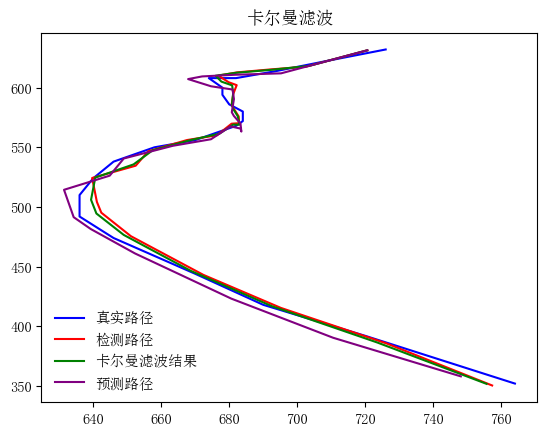

[[-5.4        -0.7       ]
 [-4.58181818 -3.77727273]
 [-1.86696035  0.88942731]
 [ 0.20809969  4.51825545]
 [ 2.00056586  1.98601069]
 [ 1.70377857  1.05589697]
 [ 2.85716089  1.93268741]
 [ 3.16304702  1.44725796]
 [ 0.82221324  0.45770473]
 [-2.79698331  2.02862495]
 [-1.45543694  1.89218001]
 [-1.02643566 -2.58195893]
 [ 1.01894224  0.95448879]
 [ 1.16876094  3.06887511]
 [ 1.10734916 -0.57406179]
 [-1.14701401  0.2172807 ]
 [-0.51547091 -2.48551873]
 [ 5.87618882 -2.3240735 ]
 [ 0.62070854  0.64769776]
 [ 3.37747443 -3.98289077]
 [ 4.95143595  2.53441544]
 [ 2.99332009  2.57928957]
 [-1.17946821  2.29714653]
 [ 2.60174957 -1.21233093]
 [ 3.49455815 -5.54628404]
 [-8.34041064 -0.23971885]]


In [12]:
path = '9.xlsx'
data_A = pd.read_excel(path, header=None)
data_A_x = list(data_A.iloc[::, 0])
data_A_y = list(data_A.iloc[::, 1])
A = np.array(list(zip(data_A_x, data_A_y)))

plt.figure()
plt.plot(data_A_x, data_A_y, 'blue')

# 检测到的路径
path = '10.xlsx'
data_B = pd.read_excel(path, header=None)
data_B_x = list(data_B.iloc[::, 0])
data_B_y = list(data_B.iloc[::, 1])
B = np.array(list(zip(data_B_x, data_B_y)))

plt.plot(data_B_x, data_B_y, 'red')

# 卡尔曼滤波
kf_params_record = np.zeros((len(data_B), 4))
kf_params_p = np.zeros((len(data_B), 4))
t = len(data_B)
kalman_filter_params = kf_init(data_B_x[0], data_B_y[0], 0, 0)
for i in range(t):
    if i == 0:
        kalman_filter_params = kf_init(data_B_x[i], data_B_y[i], 0, 0)  # 初始化
    else:            
        kalman_filter_params.z = np.transpose([data_B_x[i], data_B_y[i]])  # 设置当前时刻的观测位置
        kalman_filter_params = kf_update(kalman_filter_params)  # 卡尔曼滤波
    kf_params_record[i, ::] = np.transpose(kalman_filter_params.x)
    kf_params_p[i, ::] = np.transpose(kalman_filter_params.G)

kf_trace = kf_params_record[::, :2]
kf_trace_1 = kf_params_p[::, :2]

plt.plot(kf_trace[::, 0], kf_trace[::, 1], 'green')
plt.plot(kf_trace_1[1:26, 0], kf_trace_1[1:26, 1], 'purple')
legend = ['真实路径', '检测路径', '卡尔曼滤波结果', '预测路径']
plt.legend(legend, loc="best", frameon=False)
plt.title('卡尔曼滤波')
plt.show()

p = accuracy(kf_trace, A)
print(p)

## 第一部分：时间序列（8分）

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv('Stock_Price.csv')
df.head()


,Date,TWTR,KO,GM
0,2013-11-07,44.900002,30.350573,27.762348
1,2013-11-08,41.650002,30.518206,28.334280
2,2013-11-11,42.900002,30.381044,28.349743
3,2013-11-12,41.900002,30.388666,28.334280
4,2013-11-13,42.599998,30.571535,29.710032


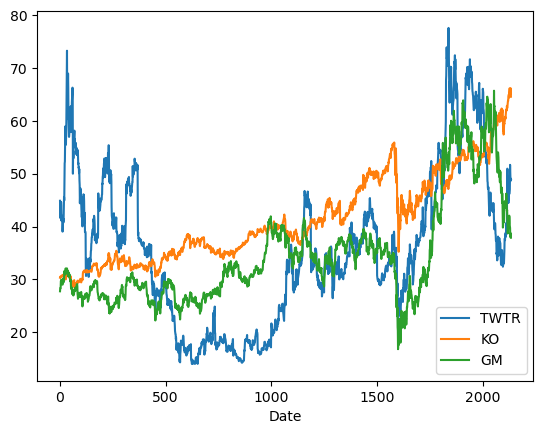

In [3]:
df[['TWTR', 'KO', 'GM']].plot()
plt.xlabel('Date')
plt.show()

1.1 请你结合课上老师讲授的知识、上次作业以及其它查阅得到的知识，对这三支股票的股价时间序列的基本性质与特征（平稳性、周期性等）进行分析，并可以尝试分析三支股票是否有（或在某些局部的时间段有）关联（2分）

1.2 请你自行发挥，根据你对于时间序列的理解并结合上网查阅资料，给出一些股票时间序列能反映趋势或可以用来预测涨跌的指标（你也可以尝试进行自定义指标），给出指标的定义以及计算指标的代码，并借助该股票数据分析效果（4分）

（没有思路的同学可以尝试计算分析股票的KDJ指标和双均线指标，分析合理即可）

1.3 噪声处理（2分）

example.wav中录制了一段鸟鸣声，但背景中存在很大的噪声，希望能编写一段程序去除噪声。这里采用的是librosa库，有关内容可参考其官方文档https://librosa.org/doc/latest/tutorial.html
<br>（1）绘制音频文件example.wav的图像。
<br>（2）去除音频文件中的噪声。（可使用scipy.signal.lfilter）https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
<br>（3）绘制去除噪声后的音频文件图像。

In [7]:
import librosa
import librosa.display
from scipy import signal
from IPython.display import Audio,display

sr = 16000
e_file='example.wav'
y,sr = librosa.load(e_file, mono=True, sr=sr, offset=0, duration=10)

display(Audio(y,rate=sr))

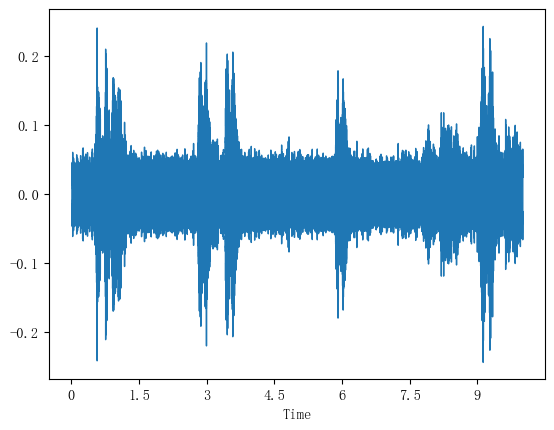

In [8]:
librosa.display.waveshow(y,sr=sr)

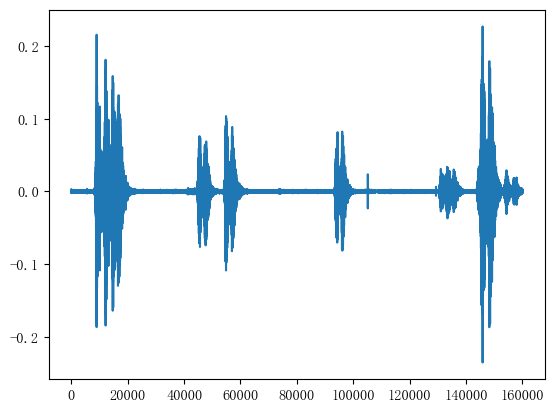

In [13]:
#todo

## 第二部分：神经网络基础(5分)

2.1补全下列常用的激活函数及其导数,熟记并画出它们的图像（2分），你也可以查阅资料后补充一些其它常用的激活函数（不计分）

In [21]:
def sigmoid(x):
    #todo
    return 1.0/(1.0 + np.exp(-x))

def d_sigmoid(x):
    #todo

def ReLU(x):
    #todo
    return max(0,x)

def d_ReLU(x):
    #todo

def Tanh(x):
    #todo
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def d_Tanh(x):
    #todo


In [22]:
#画出上述常用激活函数与对应导数在区间[-10,10]的图像
#todo

2.2使用反向传播算法，用三次函数拟合sin(x)函数在$[-\pi,\pi]$区间的取值（3分）

In [19]:
import matplotlib.pyplot as plt
import numpy as np
 
import  numpy as np
import math
#在区间等距离散采样
x = np.linspace(-math.pi,math.pi,200)
y = np.sin(x)

In [17]:
#初始化a+b*x+c*x^2+d*x^3中的参数a,b,c,d
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-5    #可尝试对比不同的学习率，不计分

In [18]:
for t in range(6000):
    y_pred = a + b*x + c*x**2 + d*x**3
    
    #计算loss（0.5分）
    #todo
 
    print(t, loss)
    
    #反向传播（1分）
    #todo
 
    # 更新参数（1分）
    #todo

 
print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')


0 907.6876885111179
1 241.90928003225423
2 112.24594027857052
3 80.06537038717482
4 66.7132631916314
5 57.9119023939453
6 50.92360339054321
7 45.10229397685266
8 40.20030992930579
9 36.061926556338136
10 32.56533391087149
11 29.609524225801373
12 27.10963624545534
13 24.994173656707762
14 23.202864249548647
15 21.684891413767488
16 20.397409563306375
17 19.304293590239727
18 18.375084681318818
19 17.584101525403277
20 16.909690938831247
21 16.3335960349002
22 15.84042349913597
23 15.41719442496828
24 15.05296560294008
25 14.738510212478422
26 14.466048598655721
27 14.229021277875823
28 14.021897548680208
29 13.840014122844384
30 13.679439067941296
31 13.536857091149635
32 13.40947281683275
33 13.29492923548094
34 13.191238944317737
35 13.096726173137776
36 13.009977903662094
37 12.929802656050102
38 12.855195739938761
39 12.785309956017613
40 12.719430893197568
41 12.656956100533044
42 12.597377526124271
43 12.54026671055858
44 12.485262302828382
45 12.43205953443444
46 12.380401344523

画出得到的三次函数与sinx在$[-\pi,\pi]$区间内的图像(0.5分)

In [ ]:
#todo